Precipitation nowcasting model which is built upon a 
CNN-ConvLSTM motion encoder and a CNN content encoder that cooperate to predict future image.
The network independently captures the spatial layout of an image and the corresponding temporal dynamics. Inspired by MCNet network.

---



Inspired from:
*   https://arxiv.org/pdf/1706.08033.pdf



**IMPORTS**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path

import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras as keras

from tensorflow.compat.v1.keras.models import Model, load_model
from tensorflow.compat.v1.keras.layers import Input, Conv2D, ConvLSTM2D, Dense, Conv2DTranspose, SeparableConv2D
from tensorflow.compat.v1.keras.layers import MaxPooling2D, UpSampling2D, Lambda, Dropout, Flatten, Reshape
from tensorflow.compat.v1.keras.layers import TimeDistributed, BatchNormalization, Concatenate
from tensorflow.compat.v1.keras.callbacks import ModelCheckpoint

tf.__version__

'1.15.0'

In [2]:
!wget http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy

--2020-03-06 16:43:57--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy’

mnist_test_seq.npy  100%[===================>] 781.25M  46.1MB/s    in 17s     

2020-03-06 16:44:20 (45.2 MB/s) - ‘mnist_test_seq.npy’ saved [819200096/819200096]



**DATA PREPROCESSING**

In [3]:
# Bring dataset in shape
xs = np.load("mnist_test_seq.npy")
xs = xs.astype(np.float32)
xs = xs / np.max(xs)
xs = np.swapaxes(xs, 0, 1)  # swap frames and observations so [obs, frames, height, width, channels]
xs = np.expand_dims(xs, -1) #Add channel dimension
print(f"Dataset shape: {xs.shape}")

Dataset shape: (10000, 20, 64, 64, 1)


In [0]:
# Motion Diff Input for Motion Encoder
def motion_diff(x):
    seqLen = len(x[0])
    return np.asarray([[x[n][i]-x[n][i-1] for i in range(1,seqLen)] for n in range(len(x))])

In [0]:
# Hyperparameters
end = 8000  #8000
seqLen = 10
x_dim, y_dim, c_dim = 64, 64, 1
fs = (3,3)  # filter size for convolutional kernels
nk = 64     # number of kernels for conv layers #48 
nd = 2048    # number of neurons in dense layers #192 

**MODEL**

In [6]:
# Inputs
dtype='float32'
contentInput = Input(shape=(x_dim, y_dim, c_dim), name='content_input', dtype=dtype)
motionInput = Input(shape=(None, x_dim, y_dim, c_dim), name='motion_input', dtype=dtype)

# Content Encoder
x = Conv2D(nk, fs, activation='relu', padding='same', name='content_conv_1')(contentInput)
x = Conv2D(nk, fs, activation='relu', padding='same', name='content_conv_new1')(x) #new
x = MaxPooling2D((2,2), name='content_pool_1')(x)
#x = BatchNormalization()(x) #new
x = Conv2D(nk*2, fs, activation='relu', padding='same', name='content_conv_2')(x)
x = Conv2D(nk*2, fs, activation='relu', padding='same', name='content_conv_new2')(x) #new
x = MaxPooling2D((2,2), name='content_pool_2')(x)
#x = Dropout(rate=0.5, name='dropout')(x)
#x = BatchNormalization()(x)#new
x = Conv2D(nk*4, fs, activation='relu', padding='same', name='content_conv_3')(x)
x = Conv2D(nk*4, fs, activation='relu', padding='same', name='content_conv_new3')(x) #new
x = Conv2D(nk*4, fs, activation='relu', padding='same', name='content_conv_new3-2')(x) #new
contentEnc = MaxPooling2D((2,2), name='content_pool_3')(x)
#x = BatchNormalization()(x)#new
#x = Flatten()(x)
#contentEnc = Dense(nd*4, activation='relu', name='content_latent')(x)

# Motion Encoder
# Layer 1
tcnv1 = TimeDistributed(Conv2D(nk, (5,5), activation='relu', padding='same'), name='motion_conv_1')(motionInput) 
x = TimeDistributed(MaxPooling2D((2,2)), name='motion_pool_1')(tcnv1) #original (2,2)
# Layer 2
tcnv2 = TimeDistributed(Conv2D(nk, (5,5), activation='relu', padding='same'), name='motion_conv_2')(x)
x = TimeDistributed(MaxPooling2D((2,2)), name='motion_pool_2')(tcnv2)
# Layer 3
tcnv3 = TimeDistributed(Conv2D(nk, (7,7), activation='relu', padding='same'), name='motion_conv_3')(x)
x = TimeDistributed(MaxPooling2D((2,2)), name='motion_pool_3')(tcnv3)
# Layer 4
motionEnc = ConvLSTM2D(nk*8, (8,8), activation='relu', padding='same', return_sequences=False, dropout=0.4, recurrent_dropout=0.4, name='motion_lstm', dtype='float32')(x)
#x = Flatten()(x)
#motionEnc = Dense(nd*4, activation='relu', name='motion_latent')(x) #relu #sigmoid before

# Combination
x = Concatenate(name='concat_layer')([motionEnc, contentEnc])  #contentEnc, motionEnc
x = Conv2D(nk*4, (3, 3), activation='relu', padding='same', name='comb_conv_1')(x)
x = Conv2D(nk*2, (3, 3), activation='relu', padding='same', name='comb_conv_new1')(x) #new
combined = Conv2D(nk*4, (3, 3), activation='relu', padding='same', name='comb_conv_new1-2')(x)

# Residuals
res3 = Lambda(lambda x: x[:,-1])(tcnv3)
res2 = Lambda(lambda x: x[:,-1])(tcnv2)
res1 = Lambda(lambda x: x[:,-1])(tcnv1)

# Decoder
x = UpSampling2D((2,2), name='decoder_upsample_1')(combined)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_1')(x)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_new1')(x) #new
x = Conv2DTranspose(nk*2, fs, activation='relu', padding='same', name='decoder_conv_new1-2')(x) #new

x = Concatenate()([x, res3]) #res3
x = UpSampling2D((2,2), name='decoder_upsample_2')(x)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_2')(x)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_new2')(x) #new

x = Concatenate()([x, res2])
x = UpSampling2D((2,2), name='decoder_upsample_3')(x)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_3')(x)
x = Concatenate()([x, res1]) #res1
#x = BatchNormalization()(x)
predictions = Conv2DTranspose(1, fs, activation='tanh', padding='same', name='prediction')(x) #sigmoid original


# Create and compile model
model = Model(inputs= [contentInput, motionInput], outputs=predictions)

optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)

model.compile(optimizer=optim, loss='mean_squared_error', metrics=["accuracy"]) #mse #cosine_similarity not give good results

#model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#Visualise Model Topology and save to file (model.png)
#from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='/model.png')

**MODEL TRAINING**

In [0]:
# Data
train_x = [xs[:end,seqLen-2], motion_diff(xs[:end,:seqLen-1])]  #list

# train_x = motion_diff(xs[:end,:seqLen-1])

train_y = xs[:end,seqLen-1]

val_x   = [xs[end:,seqLen-2], motion_diff(xs[end:,:seqLen-1])]

# val_x   = motion_diff(xs[end:,:seqLen-1])

val_y   = xs[end:,seqLen-1]


In [0]:
#Define Class to track performance (loss) hisrory
class LossHistory(keras.callbacks.Callback):
    
    def __init__(self, start_new_on_train_begin):
        self.start_new_on_train_begin = start_new_on_train_begin
        self.batches = []
        self.epochs = {'train':[], 'val':[]}
    
    def on_train_begin(self, logs={}):
        if self.start_new_on_train_begin:
            self.batches = []
            self.epochs = {'train':[], 'val':[]}

    def copy_from(self, different_loss_history):
        self.batches = different_loss_history.batches
        self.epochs = different_loss_history.epochs
            
    def on_batch_end(self, batch, logs={}):
        self.batches.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epochs['train'].append(logs.get('loss'))
        self.epochs['val'].append(logs.get('val_loss'))
loss_history = LossHistory(start_new_on_train_begin=False)

In [10]:
#Training Hyperparameters
batch_size = 50
n_epochs = 12

history = model.fit(train_x, train_y, batch_size=batch_size, 
                    epochs=n_epochs, validation_data=(val_x, val_y),
                    callbacks=[loss_history], shuffle=True) # Add shuffle=True

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8000 samples, validate on 2000 samples
Epoch 1/12
8000/8000 [==============================] - 173s 22ms/sample - loss: 0.0233 - acc: 0.9232 - val_loss: 0.0201 - val_acc: 0.9268
Epoch 2/12
8000/8000 [==============================] - 163s 20ms/sample - loss: 0.0191 - acc: 0.9247 - val_loss: 0.0185 - val_acc: 0.9264
Epoch 3/12
8000/8000 [==============================] - 163s 20ms/sample - loss: 0.0179 - acc: 0.9249 - val_loss: 0.0171 - val_acc: 0.9259
Epoch 4/12
8000/8000 [==============================] - 163s 20ms/sample - loss: 0.0167 - acc: 0.9253 - val_loss: 0.0162 - val_acc: 0.9248
Epoch 5/12
8000/8000 [==============================] - 163s 20ms/sample - loss: 0.0160 - acc: 0.9255 - val_loss: 0.0157 - val_acc: 0.9261
Epoch 6/12
8000/8000 [==============================] - 163s 20ms/sample - loss: 0.0152 - acc: 0.9257 - val_loss: 0.0147 - val_acc: 0.9262
Epoch 7/12
8000/8000 [==

In [0]:
#Save model
model.save('Moving_Mnist_prediction_(CoderDecoder_Arch).h5')

**PLOT PERFORMANCE**

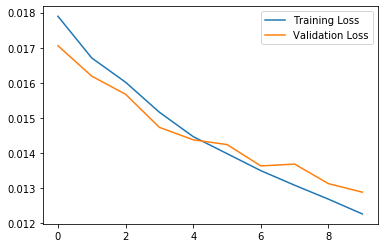

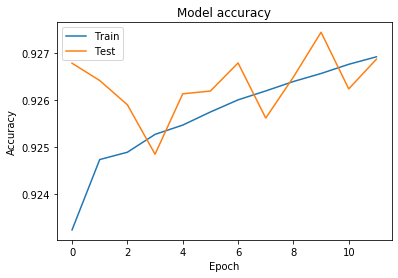

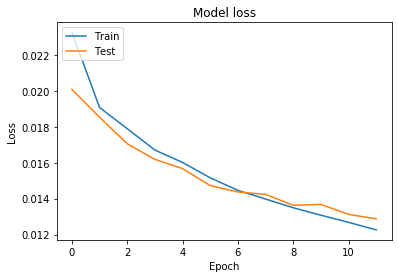

In [11]:
#Plot Training Loss vs. Validation Loss
plt.plot(loss_history.epochs['train'][2:], label='Training Loss')
plt.plot(loss_history.epochs['val'][2:], label='Validation Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
performance_history = {
    'batches':loss_history.batches,
    'epochs':loss_history.epochs
    }
with open('model_loss_history.txt', 'w') as f:
    print(performance_history, file=f)

**EVALUATION**

In [0]:
# Uncomment to 
# Load model from storage

#model_dir = '/'
#model = load_model(Path(model_dir, 'Moving_Mnist_prediction_(CoderDecoder_Arch).h5'))

In [0]:
def plot_prediction(seq_idx, plot_gt=False, use_own_predictions=False, show_label=True):
    for i, which in enumerate(seq_idx):

        if show_label: print(f"({i+1}) : {which}")

        input_length = 10 # length of input sequence
        prediction_length = 10 # length of prediction
        ground_truth = xs[which:which+1] # ground truth sequence


        if use_own_predictions:
            print("Use_own_prediction = True")
            pred = xs[which:which+1,input_length-1] # current frame
            print(pred.shape)
            input_seq = ground_truth[:,0:input_length] # input sequence (first <inputLen> frames)
            print(input_seq.shape)
            for i in range(input_length):
                # Model predicts next frame
                pred = model.predict([pred, motion_diff(input_seq)]) # return shape: (1, 64, 64, 1)
                # Cut first frame from sequence
                input_seq = np.squeeze(input_seq, axis=0)
                input_seq = input_seq[1:]
                # Append predicted frame to sequence
                input_seq = np.append(input_seq, pred, axis=0)
                input_seq = np.array([input_seq]) 
            predictions = input_seq
        
        else:
            # Use ground truth in each time step as input
            print("Use_own_prediction = False")
            print("Use Ground truth in each time step as input")
            predictions = []
            for i in range(prediction_length):
                input_seq = ground_truth[:, i:input_length+i]
                prediction = model.predict([input_seq[:,-1], motion_diff(input_seq)])
                predictions.append(prediction[0])
            predictions = np.array([predictions])
        
        figsz=(input_length*2, 1)
        
        # Plot the ground truth sequence
        if plot_gt:
            fig,axs = plt.subplots(1, input_length+prediction_length, figsize=figsz); cnt=0
            for col in axs:
                col.imshow(np.squeeze(ground_truth[0,cnt], axis=2))
                col.axis('off')
                cnt += 1   

        # Plot the input and predicted sequence
        fig,axs = plt.subplots(1, input_length+prediction_length, figsize=figsz); cnt=0
        for col in axs:
            if cnt < input_length:
                col.imshow(np.squeeze(ground_truth[0,cnt], axis=2))
            else:
                col.imshow(np.squeeze(predictions[0,cnt-input_length],axis=2))
            col.axis('off')
            cnt += 1    

        plt.show()

In [0]:
def plot_prediction2(seq_idx, plot_gt=False, show_label=True):
    for i, which in enumerate(seq_idx):

        if show_label: print(f"({i+1}) : {which}")
        inputLen = 10 # length of input sequence
        pred = xs[which:which+1,inputLen-1] # current frame
        ground_truth = xs[which:which+1] # ground truth sequence
        inputSeq = ground_truth[:,0:inputLen] # input sequence (first <inputLen> frames)

        for i in range(inputLen):
            # Model predicts next frame
            pred = model.predict([pred, motion_diff(inputSeq)]) # return shape: (1, 64, 64, 1)
            # Cut first frame from sequence
            inputSeq = np.squeeze(inputSeq, axis=0)
            inputSeq = inputSeq[1:]
            # Append predicted frame to sequence
            inputSeq = np.append(inputSeq, pred, axis=0)
            inputSeq = np.array([inputSeq])

        figsz=(inputLen*2, 1)

        # Plot the ground truth sequence
        if plot_gt:
            fig,axs = plt.subplots(1, inputLen*2, figsize=figsz); cnt=0
            for col in axs:
                col.imshow(np.squeeze(ground_truth[0,cnt], axis=2))
                col.axis('off')
                cnt += 1

        # Plot the input and predicted sequence
        fig,axs = plt.subplots(1, inputLen*2, figsize=figsz); cnt=0
        for col in axs:
            if cnt < inputLen:
                col.imshow(np.squeeze(ground_truth[0,cnt], axis=2))
            else:
                col.imshow(np.squeeze(inputSeq[0,cnt-inputLen],axis=2))
            col.axis('off')
            cnt += 1

        plt.show()

Use_own_prediction = True
(1, 64, 64, 1)
(1, 10, 64, 64, 1)


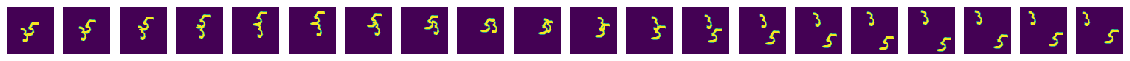

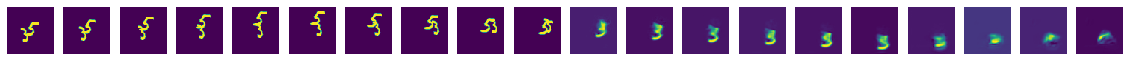

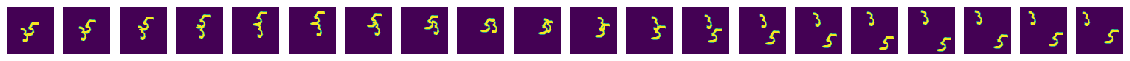

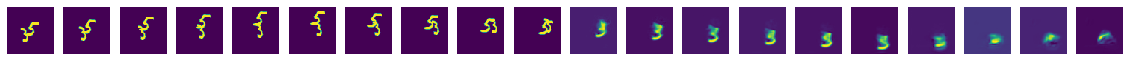

In [16]:
plot_prediction([9], plot_gt = True, use_own_predictions=True, show_label=False)

Use_own_prediction = False
Use Ground truth in each time step as input


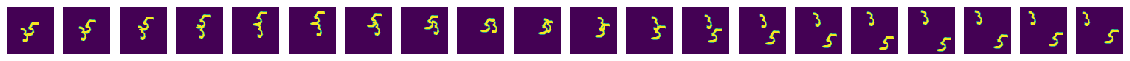

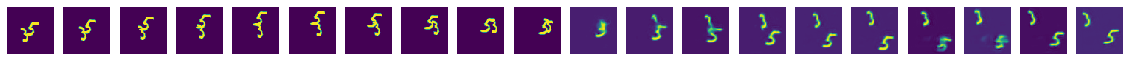

In [17]:
plot_prediction([9], plot_gt = True, use_own_predictions=False, show_label=False)